# Evaluation on skindata validation set

In [91]:
from __future__ import absolute_import
from __future__ import division

from datetime import datetime
import math
import os.path
import time
import random

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from inception import inception_eval
from inception.skin_data import SkinData
from inception import image_processing
from inception import inception_model
FLAGS = tf.app.flags.FLAGS

FLAGS.data_dir = '/ssd/esteva/skindata4/nine-way'
FLAGS.eval_dir = '/archive/esteva/experiments/skin_eval'
FLAGS.subset = 'validation'
FLAGS.num_examples = 500
FLAGS.checkpoint_dir = '/archive/esteva/experiments/skin_train'
FLAGS.input_queue_memory_factor=1
FLAGS.run_once = True

In [145]:
classnames = tf.gfile.FastGFile('/archive/esteva/skindata4/splits/nine-way/labels.txt').readlines()
classnames

['cutaneous-lymphoma\n',
 'dermal-tumor-benign\n',
 'dermal-tumor-malignant\n',
 'epidermal-tumor-benign\n',
 'epidermal-tumor-malignant\n',
 'genodermatosis\n',
 'inflammatory\n',
 'pigmented-lesion-benign\n',
 'pigmented-lesion-malignant']

# Example: use TF ops to read in image from filesystem

0.840564
0.0


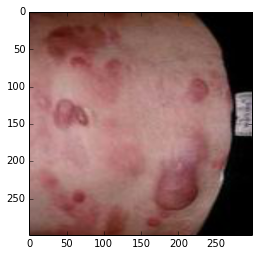

In [288]:
# Use tensorflow to read in an image from a filename
filename = '/archive/esteva/skindata4/images/httpwwwpharmacyanddrugscomillnessessimagesmycosisfungoides1jpg.jpg'

def rotate90(image):
    """Adds ops to rotate image 90 degrees. Assumes 3D tensor"""
    image = tf.image.flip_left_right(image)
    image = tf.image.transpose_image(image)
    return image

def decode_filename():
    """Returns ops that convert a filename to a 4D tensor representing an image."""
    image_raw = tf.placeholder(dtype=tf.string)
    im = tf.image.decode_jpeg(image_raw, channels=3)
    im = tf.image.convert_image_dtype(im, dtype=tf.float32)

    im = tf.image.central_crop(im, central_fraction=0.875)
    im = tf.expand_dims(im, 0)
    im = tf.image.resize_bilinear(im, [299, 299], align_corners=False)
    

#     im = tf.sub(im, 0.5)
#     im = tf.mul(im, 2.0)

    im = tf.squeeze(im, [0])
    im = rotate90(im)
    im = tf.expand_dims(im, 0)
    
    return im, image_raw

imdata = tf.gfile.FastGFile(filename, 'r').read()
image, image_raw = decode_filename()
mx = tf.reduce_max(image)
mn = tf.reduce_min(image)

with tf.Session() as sess:
    image, mx, mn = sess.run([image, mx, mn], feed_dict={image_raw : imdata})    

plt.imshow(image[0])
print mx
print mn

# Run Evaluation manually
 - feeds in one image and label at a time
 - serves as example of how to use placeholders, and of the image preprocessing steps needed to load from disk directly

In [276]:
prefix = '/archive/esteva/skindata4/splits/nine-way'
dataset = [line.strip() for line in open('/archive/esteva/skindata4/splits/nine-way/dataset.txt').readlines()]
test = [os.path.join(prefix, e) for e in dataset if '/test/' in e]
train = [os.path.join(prefix, e) for e in dataset if '/train/' in e]
classnames = ['background']
classnames.extend([line.strip() for line in open('/archive/esteva/skindata4/splits/nine-way/labels.txt').readlines()])

random.shuffle(test)

def label(entry, classnames):
    if isinstance(entry, list):
        return [label(e, classnames) for e in entry]
    d = os.path.dirname(entry)
    d = os.path.basename(d)
    return np.where(d == np.array(classnames))[0]
    

with tf.Graph().as_default(), tf.Session() as sess:
#     images, labels = image_processing.inputs(dataset)
    labels = tf.placeholder(tf.int32, shape=[1])    
    image, image_raw = decode_filename()
    
    num_classes = 9 + 1
    logits, _ = inception_model.inference(image, num_classes)
    softmax = tf.nn.softmax(logits)
    top_1_op = tf.nn.in_top_k(logits, labels, 1)
    top_5_op = tf.nn.in_top_k(logits, labels, 5)
    variable_averages = tf.train.ExponentialMovingAverage(
        inception_model.MOVING_AVERAGE_DECAY)
    variables_to_restore = variable_averages.variables_to_restore()
    saver = tf.train.Saver(variables_to_restore)
    summary_op = tf.merge_all_summaries()
    
    graph_def = tf.get_default_graph().as_graph_def()
    summary_writer = tf.train.SummaryWriter(FLAGS.eval_dir,
                                            graph_def=graph_def)


    # Load checkpoint
    ckpt = tf.train.get_checkpoint_state(FLAGS.checkpoint_dir)
    if ckpt and ckpt.model_checkpoint_path:
        if os.path.isabs(ckpt.model_checkpoint_path):
            # Restores from checkpoint with absolute path.
            saver.restore(sess, ckpt.model_checkpoint_path)
        else:
            # Restores from checkpoint with relative path.
            saver.restore(sess, os.path.join(FLAGS.checkpoint_dir,
                                             ckpt.model_checkpoint_path))

        # Assuming model_checkpoint_path looks something like:
        #   /my-favorite-path/imagenet_train/model.ckpt-0,
        # extract global_step from it.
        global_step = ckpt.model_checkpoint_path.split('/')[-1].split('-')[-1]
        print('Succesfully loaded model from %s at step=%s.' %
            (ckpt.model_checkpoint_path, global_step))
    else:
        print('No checkpoint file found')
        
    # Manually feed through the entire validation set and recreate the accuracy of the cell below
    count_top_1 = 0.0
    
    stop = 600
    correct_per_class = np.zeros(10)
    count_per_class = np.zeros(10)
    for i, entry in enumerate(test):        
        l = label(entry, classnames)
        count_per_class[l] += 1
        
        imdata = tf.gfile.FastGFile(entry, 'r').read()
        top_1, smax = sess.run([top_1_op, softmax], feed_dict={labels : l, image_raw : imdata})        
        count_top_1 += np.sum(top_1)
        correct_per_class[l] += np.sum(top_1)
        
        if i % 10 == 0:
            print '\r', i,
        
        if i == stop: 
            break
    
    precision_at_1 = 1.0 * count_top_1 / stop
    acc_per_class = 1.0 * correct_per_class / count_per_class
        
print '\nPrecision @ 1:', precision_at_1
print 'Accuracy per class:'
for e, name in zip(acc_per_class, classnames):
    print '%0.3f %s' % (e, name)
print 'Mean Accuracy: %0.4f' % np.mean(acc_per_class[1:])
    

Succesfully loaded model from /archive/esteva/experiments/skin_train/model.ckpt-215000 at step=215000.
600 
Precision @ 1: 0.828333333333
Accuracy per class:
nan background
0.333 cutaneous-lymphoma
0.469 dermal-tumor-benign
0.000 dermal-tumor-malignant
0.586 epidermal-tumor-benign
0.603 epidermal-tumor-malignant
0.412 genodermatosis
0.936 inflammatory
0.667 pigmented-lesion-benign
0.200 pigmented-lesion-malignant
Mean Accuracy: 0.4673


# Run Evaluation using batches (fast):
 - this essentially dissects inception/inception_eval.py

In [267]:
dataset = SkinData(subset='validation')
# inception_eval.evaluate(dataset)

with tf.Graph().as_default(), tf.Session() as sess:
    images, labels = image_processing.inputs(dataset)
    num_classes = dataset.num_classes() + 1
    logits, _ = inception_model.inference(images, num_classes)
    softmax = tf.nn.softmax(logits)
    top_1_op = tf.nn.in_top_k(logits, labels, 1)
    top_5_op = tf.nn.in_top_k(logits, labels, 5)
    variable_averages = tf.train.ExponentialMovingAverage(
        inception_model.MOVING_AVERAGE_DECAY)
    variables_to_restore = variable_averages.variables_to_restore()
    saver = tf.train.Saver(variables_to_restore)
    summary_op = tf.merge_all_summaries()
    
    graph_def = tf.get_default_graph().as_graph_def()
    summary_writer = tf.train.SummaryWriter(FLAGS.eval_dir,
                                            graph_def=graph_def)


    # Load checkpoint
    ckpt = tf.train.get_checkpoint_state(FLAGS.checkpoint_dir)
    if ckpt and ckpt.model_checkpoint_path:
        if os.path.isabs(ckpt.model_checkpoint_path):
            # Restores from checkpoint with absolute path.
            saver.restore(sess, ckpt.model_checkpoint_path)
        else:
            # Restores from checkpoint with relative path.
            saver.restore(sess, os.path.join(FLAGS.checkpoint_dir,
                                             ckpt.model_checkpoint_path))

        # Assuming model_checkpoint_path looks something like:
        #   /my-favorite-path/imagenet_train/model.ckpt-0,
        # extract global_step from it.
        global_step = ckpt.model_checkpoint_path.split('/')[-1].split('-')[-1]
        print('Succesfully loaded model from %s at step=%s.' %
            (ckpt.model_checkpoint_path, global_step))
    else:
        print('No checkpoint file found')
        

    # Start the queue runners.
    coord = tf.train.Coordinator()
    try:
        threads = []
        for qr in tf.get_collection(tf.GraphKeys.QUEUE_RUNNERS):            
            threads.extend(qr.create_threads(sess, coord=coord, daemon=True,
                                             start=True))

        num_iter = int(math.ceil(FLAGS.num_examples / FLAGS.batch_size))
        # Counts the number of correct predictions.
        count_top_1 = 0.0
        count_top_5 = 0.0
        total_sample_count = num_iter * FLAGS.batch_size
        step = 0
        correct_per_class = np.zeros(num_classes)
        count_per_class = np.zeros(num_classes)
        

        print('%s: starting evaluation on (%s).' % (datetime.now(), FLAGS.subset))
        start_time = time.time()
        while step < num_iter and not coord.should_stop():
            top_1, top_5, smax, l = sess.run([top_1_op, top_5_op, softmax, labels])
            preds = np.argmax(smax, axis=1)
            for ll, p in zip(l, preds):
                count_per_class[ll] += 1
                correct_per_class[ll] += ll == p
            
            count_top_1 += np.sum(top_1)
            count_top_5 += np.sum(top_5)
            step += 1
            if step % 20 == 0:
                duration = time.time() - start_time
                sec_per_batch = duration / 20.0
                examples_per_sec = FLAGS.batch_size / sec_per_batch
                print('%s: [%d batches out of %d] (%.1f examples/sec; %.3f'
                    'sec/batch)' % (datetime.now(), step, num_iter,
                                    examples_per_sec, sec_per_batch))
                start_time = time.time()
                
        acc_per_class = 1.0 * correct_per_class / count_per_class

        # Compute precision @ 1.
        precision_at_1 = count_top_1 / total_sample_count
        recall_at_5 = count_top_5 / total_sample_count
        print('%s: precision @ 1 = %.4f recall @ 5 = %.4f [%d examples]' %
            (datetime.now(), precision_at_1, recall_at_5, total_sample_count))

        summary = tf.Summary()
        summary.ParseFromString(sess.run(summary_op))
        summary.value.add(tag='Precision @ 1', simple_value=precision_at_1)
        summary.value.add(tag='Recall @ 5', simple_value=recall_at_5)
        summary_writer.add_summary(summary, global_step)

    except Exception as e:  # pylint: disable=broad-except
        coord.request_stop(e)

    coord.request_stop()
    coord.join(threads, stop_grace_period_secs=10)


Succesfully loaded model from /archive/esteva/experiments/skin_train/model.ckpt-215000 at step=215000.
2016-06-09 14:59:46.055811: starting evaluation on (validation).
2016-06-09 14:59:53.070002: precision @ 1 = 0.8418 recall @ 5 = 0.9707 [512 examples]


In [274]:
print 'Accuracies'
for e, name in zip(acc_per_class, classnames):
    print '%0.3f %s' % (e, name)
    
print 'Mean Accuracy Per Class: %0.3f' % np.mean(acc_per_class[1:])

Accuracies
nan background
0.167 cutaneous-lymphoma
0.471 dermal-tumor-benign
0.000 dermal-tumor-malignant
0.350 epidermal-tumor-benign
0.640 epidermal-tumor-malignant
0.400 genodermatosis
0.958 inflammatory
0.750 pigmented-lesion-benign
0.375 pigmented-lesion-malignant
Mean Accuracy Per Class: 0.457


0.45668329320032108